# HTCC Trends Over Time: Calibration Analysis

This notebook is designed to help visualize calibration data from HTCC (High Threshold Cherenkov Counter) experiments, focusing on the gains and timing of the PMTs (Photomultiplier Tubes) over a series of runs. 

### Data Requirements and Structure

- **Directory Structure:**  
  The notebook expects a file path that contains subdirectories named after various run numbers. Each subdirectory should contain the output from the calibration script `OneScriptToRunThemAll.sh`, which is generated by processing HTCC skims of the corresponding run.
  
- **Essential Data:**  
  Without the calibration outputs (i.e., the data generated by `OneScriptToRunThemAll.sh`), this notebook will not run. Make sure that the directory paths are correctly set up and that the calibration data for each run is available.

### Purpose and Context

- **Mini Timeline Visualization:**  
  The primary goal is to create "mini timelines" that focus solely on the runs selected for additional calibration. While full timelines are available via the run groups (for example, at [CLAS12 Monitor Timeline](https://clas12mon.jlab.org/rga/pass2/sp18/pass0/sp18_v0.24/htcc/timeline/)), those include all runs and can take a long time to generate.

- **Focused Analysis:**  
  By narrowing down to these specific runs, we can:
  - Quickly visualize and compare the behavior of calibration constants (like gain and timing) over time.
  - Identify trends that are critical for making decisions about which run ranges to calibrate further.
  - Gain a detailed look at the calibration quality and behavior, supporting more informed decision-making.

This notebook is organized into sections covering:
- Environment setup and library imports.
- Utility functions for data processing and plotting.
- Step-by-step examples that demonstrate how to generate and customize the plots.
- Guidelines for troubleshooting and extending the analysis.

## Environment Setup

In this section, we import all the required libraries and configure our plotting styles. These libraries include NumPy for numerical operations, Pandas for data manipulation, Matplotlib and Seaborn for plotting, and modules such as `glob` and `os` for file operations. This setup is essential for running the subsequent analysis.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set Seaborn style for better plot aesthetics
sns.set(style="whitegrid")

*Explanation:*  
- **NumPy & Pandas:** Used for data manipulation and calculations.  
- **Matplotlib & Seaborn:** Provide powerful plotting capabilities.  
- **glob & os:** Facilitate file handling and directory operations, crucial for reading calibration data from multiple run subdirectories.

## Utility Functions

This section defines the core functions that will process the calibration data and generate plots. These functions are designed to:
- Clean run number strings.
- Process and load calibration data from the specified directories.
- Calculate average calibration values over a specific run range.
- Generate customizable scatter plots to visualize calibration trends over time.

### Function: `deleteLeadingZeros`

This helper function strips leading zeros from a string representing a run number.  

In [3]:
def deleteLeadingZeros(inputString):
    """
    Remove leading zeros from the input string. 
    If the string becomes empty, return "0".
    """
    return inputString.lstrip('0') or "0"

### Function: `plot_data`

Generates a scatter plot of calibration constants over run numbers with options for customization like axis ranges, horizontal/vertical reference lines, and date filters.

In [4]:
def plot_data(dataframe_list, y_column, h_lines=None, v_lines=None, y_range=None, x_range=None, date_filter=None):
    """
    Plot a list of pandas dataframes with a specified y-column. 
    The x-axis represents run numbers, with data points colored and styled by sector information.

    Parameters
    ----------
    dataframe_list : list
        List of pandas dataframes.
    y_column : str
        Column name to be plotted on the y-axis.
    h_lines : list, optional
        List of y-values for horizontal lines.
    v_lines : list, optional
        List of x-values for vertical lines.
    y_range : tuple, optional
        (min, max) values for the y-axis.
    x_range : tuple, optional
        (min, max) values for the x-axis (run numbers).
    date_filter : list of str, optional
        List of dates (format 'DD-Mon-YYYY') to include in the plot.

    Returns
    -------
    None
    """
    df = pd.concat(dataframe_list)
    
    if date_filter:
        df = df[df['Date'].isin(date_filter)]
    
    df['Sector'] = df['Sector'].astype('category')
    df['Ring'] = df['Ring'].astype('category')
    df['RunNum'] = df['RunNum'].astype(int)

    palette = sns.color_palette('colorblind', len(df['Sector'].unique()))
    
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x='RunNum', y=y_column, hue='Ring', style='Sector', palette=palette, data=df, s=100)
    
    if h_lines:
        for h_line in h_lines:
            plt.axhline(h_line, color='gray', linestyle='--')
    
    if v_lines:
        for v_line in v_lines:
            plt.axvline(v_line, color='gray', linestyle='--')

    if y_range:
        plt.ylim(y_range)

    if x_range:
        plt.xlim(x_range)
    else:
        plt.xlim(df['RunNum'].min(), df['RunNum'].max())

    plt.legend(title='Sector')
    plt.title(f'Plot of {y_column} by RunNum and Sector')
    plt.xlabel('Run Number')
    plt.ylabel(y_column)
    plt.show()

### Function: `process_data`

This function processes calibration data for gain and timing from specified superdirectories and dates. It assumes each run subdirectory contains the output of the calibration script `OneScriptToRunThemAll.sh`.

In [5]:
def process_data(superdirectories, dates):
    """
    Process calibration data by iterating over given superdirectories and dates. 
    Expects each run subdirectory to contain calibration outputs from `OneScriptToRunThemAll.sh`.

    Parameters
    ----------
    superdirectories : list
        List of parent directories containing subdirectories for different run numbers.
    dates : list
        List of dates (format 'DD-Mon-YYYY') corresponding to the calibration outputs.

    Returns
    -------
    tuple : Two lists of pandas dataframes
        - list_df_gain: Dataframes containing gain calibration data.
        - list_df_time: Dataframes containing time calibration data.
    """
    list_df_gain = []
    list_df_time = []

    for superdir in superdirectories:
        for subDate in dates:
            pathdirs = glob.glob(superdir + "*/")
            
            for path in pathdirs:
                run_num = int(deleteLeadingZeros(os.path.basename(os.path.dirname(path))))
                savePath = f"{path}/{subDate}/"
                
                if not os.path.exists(savePath):
                    print(f"Skipping {savePath} as it doesn't exist.")
                    continue

                print(f"Processing {savePath} for run number {run_num}")

                # Load and process gain data
                df_gain_path = f"{savePath}correctionFactor_NphePMT{run_num}.dat"
                if os.path.exists(df_gain_path):
                    df_gain = pd.read_csv(df_gain_path)
                    df_gain["RunNum"] = run_num
                    df_gain["Date"] = subDate
                    list_df_gain.append(df_gain)

                # Load and process time data
                df_time_path = f"{savePath}correctionFactor_TimePMT{run_num}.dat"
                if os.path.exists(df_time_path):
                    df_time = pd.read_csv(df_time_path)
                    df_time["RunNum"] = run_num
                    df_time["Date"] = subDate
                    list_df_time.append(df_time)
    
    return list_df_gain, list_df_time

### Function: `calculate_average`

Calculates the average of a specified calibration constant over a provided run range. This function is useful for determining baseline trends or thresholds to display as reference lines on the plots.

In [6]:
def calculate_average(dataframe_list, column, run_range):
    """
    Calculate the average value of a given column over a specified run range.

    Parameters
    ----------
    dataframe_list : list
        List of pandas dataframes containing calibration data.
    column : str
        Column name for which the average is calculated.
    run_range : tuple
        Tuple specifying the inclusive lower and upper bounds of the run numbers.

    Returns
    -------
    float
        The average value of the specified column within the run range.
    """
    df = pd.concat(dataframe_list)
    df_filtered = df[(df['RunNum'] >= run_range[0]) & (df['RunNum'] <= run_range[1])]
    return df_filtered[column].mean()

*Explanation:*  
- **deleteLeadingZeros:** Ensures that run numbers are correctly processed without extra zeros.  
- **plot_data:** Provides a flexible interface for plotting the calibration constants with customization options such as filtering by date and highlighting reference values.  
- **process_data:** Automates data loading from the required directory structure; it searches for calibration outputs produced by `OneScriptToRunThemAll.sh` and creates dataframes for gain and timing data.  
- **calculate_average:** Computes the average value of a specified calibration constant over a particular run range, which is useful for generating reference lines in the plots.

## Data Processing

Before running the full analysis, it’s helpful to explore your data directories and see what files are available. Since you’re running this locally, you can use shell commands to list directory contents.

### 1. Inspecting the Data Directory

You can use a shell command within the notebook to list the files in your data directory. Replace `/path/to/your/data/` with the actual path where your run directories are stored.

In [8]:
!pwd

/Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025


In [9]:
!ls

003867
003903
003916
003938
003971
004139
HTCC_Calibrations.pptx
Slides.ipynb
TrendsOverTime.ipynb
TrendsOverTime_CalibrationAnalysis.ipynb


*Explanation:*  
Run this command in a superdirectory that contains the output from `OneScriptToRunThemAll.sh`. This command will display the subdirectories, each named after a run number. Within those run directories you will see a dated directory (or multiple) for when you ran the calibration scripts. 

### 2. Examining a Specific Run Directory

Once you see the list of run directories, choose one run (for example, `003867`) and list its contents to see the calibration outputs.

In [13]:
!ls 003867/18-Feb-2025

Combo_GainTime_003867.png            compareRun3867CCDB_HTML.txt
Combo_GainTime_3867.png              correctionFactor_NphePMT3867.dat
Combo_GainTime_3867_resized.png      correctionFactor_TimePMT3867.dat
Combo_Info_003867.png                infoplots_NPHE3867.png
Combo_Info_3867.png                  infoplots_Time3867.png
CompareCSV_Run3867_Combo.png         npeAllC3867.png
CompareCSV_Run3867_Combo_resized.png npePMT3867.dat
CompareCSV_Run3867_Gain.png          nphePMT3867.png
CompareCSV_Run3867_Time.png          nphePMT_ZOOM_3867.png
ccdb_gain_run003867.dat              timeAllC3867.png
ccdb_time_run003867.dat              timePMT3867.dat
compareRun3867CCDB.dat               timePMT3867.png


*Explanation:*  
This helps verify that the expected calibration files (such as `correctionFactor_NphePMT3050.dat` and `correctionFactor_TimePMT3050.dat`) are present.

### 3. Loading and Inspecting the Data

After confirming that the files exist, you can use the provided utility function `process_data` to load the data. Once loaded, you might want to inspect the dataframe structure and column names.

In [28]:
# Define your data paths and dates (modify these as needed)
superdirectories = ["/Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/"]
dates = ["18-Feb-2025"]

# Process the calibration data using the utility function
list_df_gain, list_df_time = process_data(superdirectories, dates)

# Inspect the first dataframe from the gain data list (if available)
if list_df_gain:
    df_example = list_df_gain[0]
    print("Column Names for Gains:")
    print(df_example.columns.tolist())
    print("\nFirst 5 Rows:")
    display(df_example.head())
else:
    print("No gain data found.")

Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/003938//18-Feb-2025/ for run number 3938
Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/003867//18-Feb-2025/ for run number 3867
Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/003971//18-Feb-2025/ for run number 3971
Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/004139//18-Feb-2025/ for run number 4139
Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/003903//18-Feb-2025/ for run number 3903
Processing /Users/iillari/Documents/jlab/HTCC/RGA/18Feb2025/003916//18-Feb-2025/ for run number 3916
Column Names for Gains:
['Sector', 'HalfSector', 'Ring', 'Mean', 'StdDev', 'AverageNPE', 'Factor', 'gainTableValue', 'NewNphe', 'Difference', 'PercentChange', 'RunNum', 'Date']

First 5 Rows:


,Sector,HalfSector,Ring,Mean,StdDev,AverageNPE,Factor,gainTableValue,NewNphe,Difference,PercentChange,RunNum,Date
0,1,1,1,13.943596,7.116601,13.119063,1.062850,250.733878,266.492492,15.758613,6.284996,3938,18-Feb-2025
1,1,2,1,13.387928,7.227358,13.119063,1.020494,222.033461,226.583862,4.550401,2.049421,3938,18-Feb-2025
2,2,1,1,14.381250,6.666749,13.119063,1.096210,255.219426,279.774126,24.554700,9.621015,3938,18-Feb-2025
3,2,2,1,12.739951,7.019396,13.119063,0.971102,139.789725,135.750110,-4.039615,-2.889780,3938,18-Feb-2025
4,3,1,1,14.082122,6.860636,13.119063,1.073409,241.175806,258.880302,17.704496,7.340909,3938,18-Feb-2025


*Explanation:*  
- The above code processes the data from your directories and prints the column names along with a preview of the first few rows.  
- This gives you an idea of the structure of your calibration data and helps identify which columns you might want to filter on.

### 4. Filtering Dataframes for Specific Information

Once you know the column names, you can filter the dataframes to focus on specific information. For example, suppose you want to filter the data to see only entries where the percent change in the gains is between certain values.

In [21]:
# Filter the dataframe to include only rows with PercentChange values in a certain range
if list_df_gain:
    df_filtered = df_example[ (df_example['PercentChange'] < 5.0) & (df_example['PercentChange'] > 0) ]
    print("Filtered Data (0% < PercentChange < 5%):")
    display(df_filtered)
else:
    print("No gain data to filter.")

Filtered Data (0% < PercentChange < 5%):


,Sector,HalfSector,Ring,Mean,StdDev,AverageNPE,Factor,gainTableValue,NewNphe,Difference,PercentChange,RunNum,Date
1,1,2,1,13.387928,7.227358,13.119063,1.020494,222.033461,226.583862,4.550401,2.049421,3938,18-Feb-2025
5,3,2,1,13.187483,6.520120,13.119063,1.005215,190.458533,191.451825,0.993292,0.521527,3938,18-Feb-2025
7,4,2,1,13.362835,7.232195,13.119063,1.018581,156.390935,159.296912,2.905978,1.858150,3938,18-Feb-2025
8,5,1,1,13.593127,7.129589,13.119063,1.036136,170.061340,176.206592,6.145252,3.613550,3938,18-Feb-2025
10,6,1,1,13.419089,6.529023,13.119063,1.022869,238.245026,243.693560,5.448534,2.286945,3938,18-Feb-2025
12,1,1,2,13.311463,6.477137,13.119063,1.014666,290.382449,294.641105,4.258656,1.466568,3938,18-Feb-2025
13,1,2,2,13.543765,6.409917,13.119063,1.032373,371.750412,383.785038,12.034625,3.237286,3938,18-Feb-2025
14,2,1,2,13.357675,7.147477,13.119063,1.018188,180.610814,183.895788,3.284974,1.818814,3938,18-Feb-2025
16,3,1,2,13.150678,6.415123,13.119063,1.002410,233.607529,234.170480,0.562951,0.240982,3938,18-Feb-2025
22,6,1,2,13.324400,7.232511,13.119063,1.015652,209.240689,212.515669,3.274980,1.565174,3938,18-Feb-2025


*Explanation:*  
- This snippet filters the example dataframe for rows where the 'PercentChange' column is above 0% but below 5%.  
- You can modify the filtering condition based on your specific requirements.

## 5. Example Plots & Analysis

This section demonstrates how to generate different plots using the utility functions provided earlier. Each example focuses on a specific aspect of the calibration data, allowing you to quickly visualize trends in gains and timing over selected runs.

### Example 1: Basic Scatter Plot of Gain Calibration Data

In this example, we plot the gain calibration values (the "Mean" column) against run numbers for a selected date. The code uses the default settings of the `plot_data` function.

/var/folders/yz/s93gkny92rbbt6t_zgx678180000gq/T/ipykernel_20411/2601461725.py:39: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x='RunNum', y=y_column, hue='Ring', style='Sector', palette=palette, data=df, s=100)


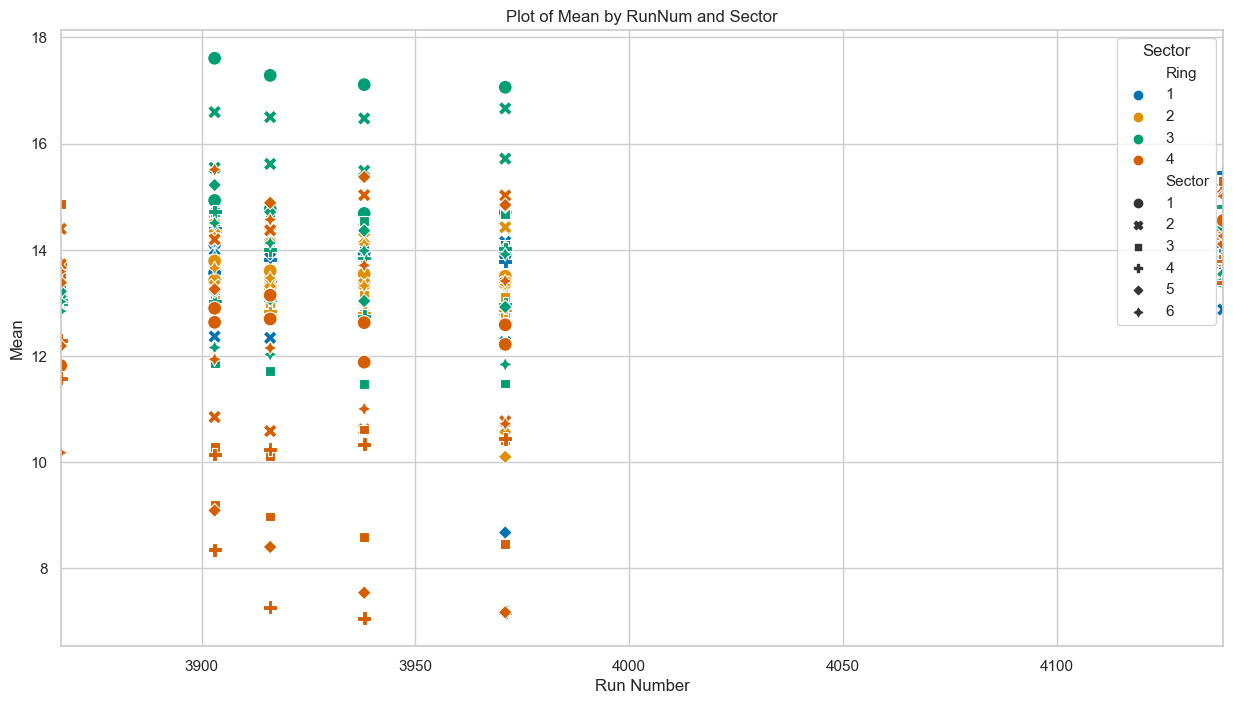

In [22]:
# Example 1: Basic Plot of Gain Data
# Plot the "Mean" column against run numbers for the specified date.
plot_data(list_df_gain, y_column="Mean", date_filter=["18-Feb-2025"])

*Explanation:*  
This plot creates a scatter plot where each point corresponds to a run. The x-axis represents the run number and the y-axis represents the gain calibration value ("Mean"). The points are colored by "Ring" and styled by "Sector".

### Example 2: Plot with Custom x-axis Range and Horizontal Reference Line

Often, it's useful to zoom in on a specific portion of the data and highlight a reference value. In this example, we:
- Zoom in to a specific run number range using `x_range`.
- Draw a horizontal line to represent the average gain over a given run range using the `calculate_average` function.

In [24]:
# Calculate the average gain for a specified run range (e.g., all RGA Spring 2018 runs 3029 to 4326)
average_mean_gain_rga_s18 = calculate_average(list_df_gain, column="Mean", run_range=(3029, 4326))
print(f"Average Mean NPHE for runs 3029 to 4326: {average_mean_gain_rga_s18}")

# mean for runs 3900 to 3950
average_mean_gain_subset = calculate_average(list_df_gain, column="Mean", run_range=(3900, 3950))
print(f"Average Mean NPHE for runs 3900 to 3950: {average_mean_gain_subset}")

Average Mean NPHE for runs 3029 to 4326: 13.301109091171165
Average Mean NPHE for runs 3900 to 3950: 13.24532885640763


/var/folders/yz/s93gkny92rbbt6t_zgx678180000gq/T/ipykernel_20411/2601461725.py:39: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x='RunNum', y=y_column, hue='Ring', style='Sector', palette=palette, data=df, s=100)


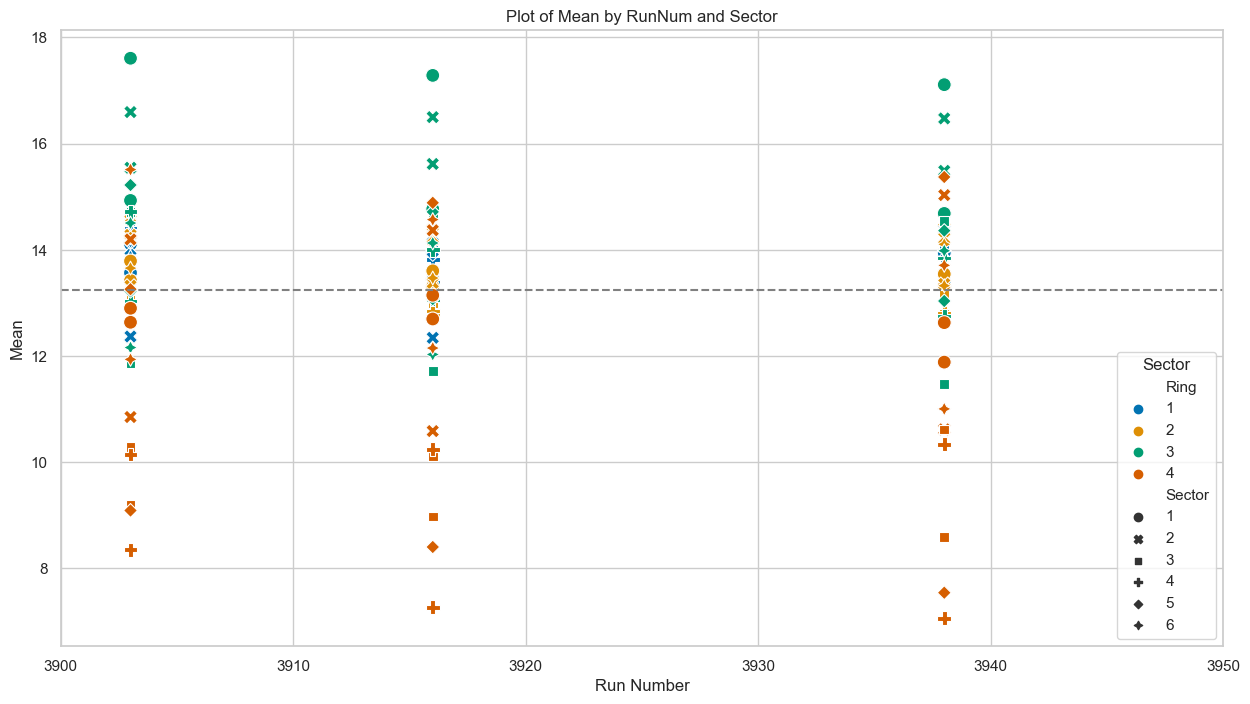

In [25]:
# Create a plot focusing on a subset of runs with the average gain shown as a horizontal line.
plot_data(list_df_gain, y_column="Mean", 
          x_range=(3900, 3950), 
          date_filter=["18-Feb-2025"], 
          h_lines=[average_mean_gain_subset])

*Explanation:*  
By specifying `x_range`, this plot zooms into runs 3800 through 4200. The horizontal line at the average gain (calculated from runs 3029 to 4326) provides a visual benchmark for comparing individual run performance.

### Example 3: Plot with Vertical Reference Lines for Key Run Numbers

In this example, we add vertical reference lines to highlight important run numbers (perhaps marking changes in experimental conditions or calibration events).

In [30]:
average_timeshift = calculate_average(list_df_time, column="TimeShift", run_range=(3029, 4326))
print(f"Average Time Shift for runs 3029 to 4326: {average_timeshift}")

Average Time Shift for runs 3029 to 4326: -0.016337973390763885


/var/folders/yz/s93gkny92rbbt6t_zgx678180000gq/T/ipykernel_20411/2601461725.py:39: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x='RunNum', y=y_column, hue='Ring', style='Sector', palette=palette, data=df, s=100)


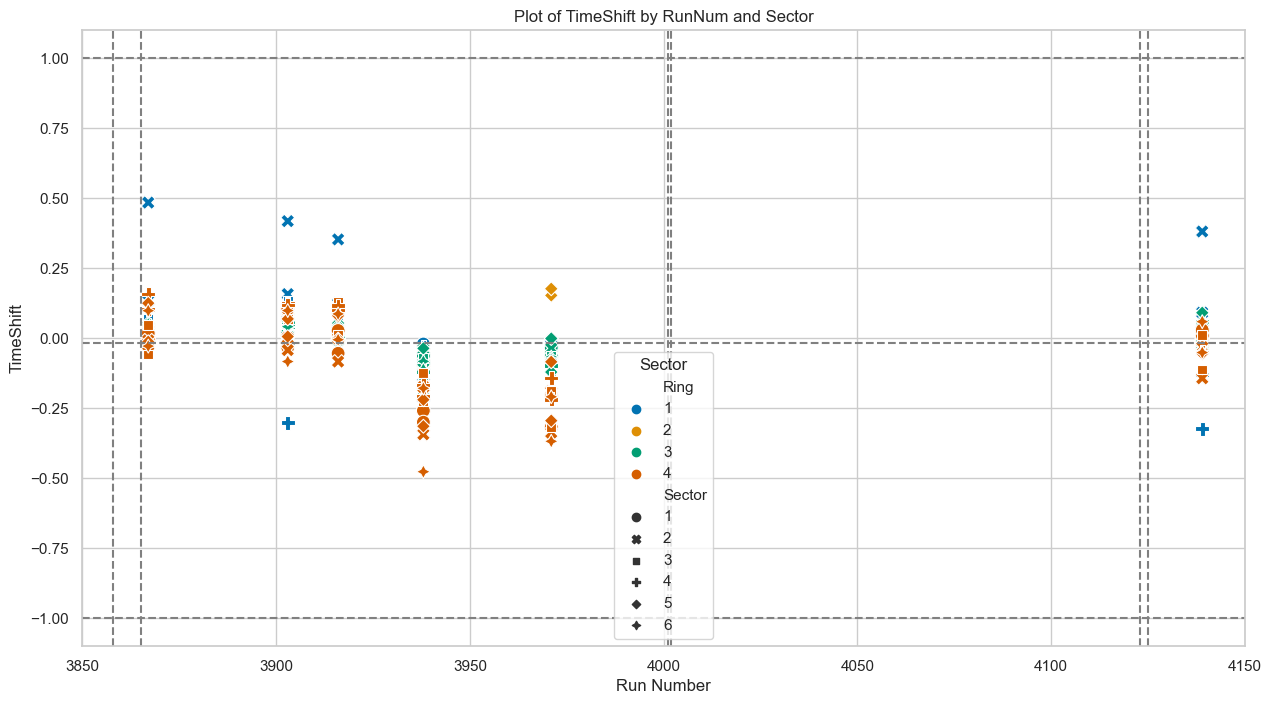

In [35]:
# Example 3: Plot with Vertical Reference Lines

# Suppose these run numbers are significant; add vertical lines at these runs.
# I put lines for some subsets of runs that had empty target 3858-3865, 4001-4002. 4123-4125
significant_runs = [3858, 3865, 4001, 4002, 4123, 4125]

# Create a plot with these vertical reference lines.
plot_data(list_df_time, y_column="TimeShift", 
          x_range=(3850, 4150), 
          date_filter=["18-Feb-2025"], 
          v_lines=significant_runs,
          h_lines=[average_timeshift, -1, 1] #+/-1 ns are the QA boundaries for timing
         )

*Explanation:*  
Vertical lines can help you identify shifts or anomalies in the calibration data relative to specific runs.

### Example 4: Custom y axis

In this example, we add change the range of the y axis.

/var/folders/yz/s93gkny92rbbt6t_zgx678180000gq/T/ipykernel_20411/2601461725.py:39: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(x='RunNum', y=y_column, hue='Ring', style='Sector', palette=palette, data=df, s=100)


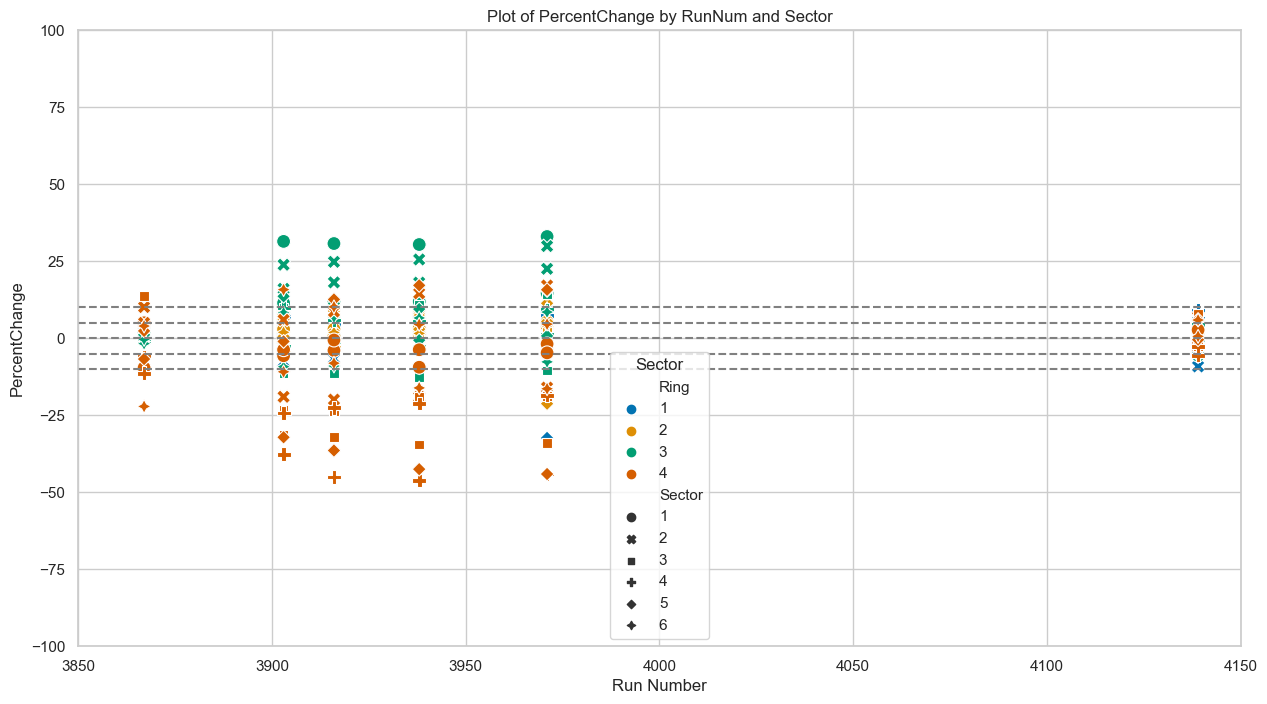

In [41]:
# Example: Custom y-axis range to better visualize small variations.
plot_data(list_df_gain, y_column="PercentChange", 
          x_range=(3850, 4150), 
          y_range=(-100, 100), 
          date_filter=["18-Feb-2025"],
          h_lines=[0, -5, 5, -10, 10]
         )

# Explore your own code and plots down here